In [358]:
import numpy as np
from numpy import random
from numpy.lib.scimath import sqrt
import matplotlib.pyplot as plt
from statistics import mean
from scipy.stats import pearsonr
from scipy.stats import chi2
from scipy import stats

In [174]:
def get_without_zeros(system_of_random_vars, cumulative_X):
    zeroes_indexes = []
    for i in range(len(system_of_random_vars)):
        for j in range(len(system_of_random_vars[0])):
            if system_of_random_vars[i, j] == 0:
                zeroes_indexes.append([i, j])

    indexes_to_skip = []
    for i in range(len(cumulative_X)):
        index_X = i // X_size
        index_Y = i % Y_size
        if zeroes_indexes.count([index_X, index_Y]):
            indexes_to_skip.append(i)

    indexes = []
    for i in range(len(cumulative_X)):
        indexes.append(i)
    
    return set(indexes) - set(indexes_to_skip)

In [197]:
def calculate_indexes(X_set, Y_set, empirical_matrix):
    index_X = j // X_size 
    index_Y = j % Y_size
    X_set.append(index_X)
    Y_set.append(index_Y)
    empirical_matrix[index_X, index_Y] += 1

In [362]:
system_of_random_vars = np.array([[0, 0.11, 0.12, 0.03],
                                     [0, 0.13, 0.09, 0.02],
                                     [0.02, 0.11, 0.08, 0.01],
                                     [0.03, 0.11, 0.05, 0.09]])

num_of_elements = 100000
X = np.array([0, 1, 2, 3])
Y = np.array([0, 1, 2, 3])
X_size = len(X)
Y_size = len(Y)

empirical_matrix = np.zeros((len(system_of_random_vars), len(system_of_random_vars[0])))

system_of_RVs_X = system_of_random_vars.flatten(order='C')
cumulative_X = np.cumsum(system_of_RVs_X)

cumulative_X_cleared = get_without_zeros(system_of_random_vars, cumulative_X)

X_set = []
Y_set = []

for i in range(num_of_elements):
    random_value = np.random.uniform()
    for j in cumulative_X_cleared:
        if j == 0:
            calculate_indexes(X_set, Y_set, empirical_matrix)
            break
        elif random_value > cumulative_X[j-1] and random_value <= cumulative_X[j]:
            calculate_indexes(X_set, Y_set, empirical_matrix)
            break

for i in range(len(empirical_matrix)):
    for j in range(len(empirical_matrix[0])):
        empirical_matrix[i, j] = empirical_matrix[i, j] / num_of_elements
    
print(f"Empirical matrix:\n {empirical_matrix}")
print(f"\nTheoretical matrix:\n {system_of_random_vars}")

Empirical matrix:
 [[0.      0.10988 0.11889 0.03026]
 [0.      0.12957 0.09155 0.0205 ]
 [0.02007 0.10959 0.08039 0.01019]
 [0.03026 0.11078 0.04785 0.09022]]

Theoretical matrix:
 [[0.   0.11 0.12 0.03]
 [0.   0.13 0.09 0.02]
 [0.02 0.11 0.08 0.01]
 [0.03 0.11 0.05 0.09]]


Text(0.5, 0, 'Y set')

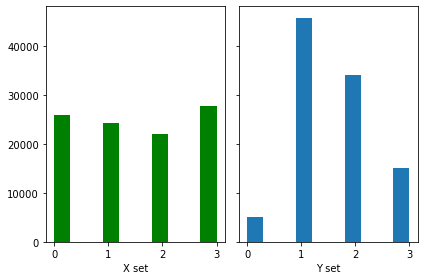

In [214]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(X_set, label="X set", color='green')
axs[1].hist(Y_set, label="Y set")
axs[0].set_xlabel('X set')
axs[1].set_xlabel('Y set')

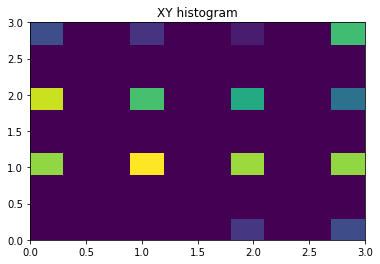

In [215]:
plt.title('XY histogram')
plt.hist2d(X_set, Y_set)
plt.show()

In [297]:
def calculate_mean(sample, values, probabilities_theor, probabilities_emp):
    empirical_mean = sum([value * pi for value, pi in zip(values, probabilities_emp)])
    theoretical_mean = sum([value * pi for value, pi in zip(values, probabilities_theor)])
    return empirical_mean, theoretical_mean

In [289]:
def calculate_variance(sample, values, empirical_mean, theoretical_mean):
    empirical_variance = sum([(x - empirical_mean) ** 2 for x in sample]) / (len(sample)-1)
    theoretical_variance = sum([(x - theoretical_mean) ** 2 for x in sample]) / (len(sample)-1)
    
    return empirical_variance, theoretical_variance

In [270]:
def calc_confidence_interval_mean(empirical_variance, empirical_mean, num_of_elements):
    student_coeff = 2.5758293
    lower_limit = empirical_mean - student_coeff* sqrt(empirical_variance) / sqrt(num_of_elements)
    upper_limit = empirical_mean + student_coeff * sqrt(empirical_variance) / sqrt(num_of_elements)
    return lower_limit, upper_limit

In [263]:
def calc_confidence_interval_variance(variance, num_of_elements, alpha):
    lower_limit = (num_of_elements - 1) * variance / stats.chi2.ppf(1 - alpha / 2, num_of_elements - 1)
    upper_limit = (num_of_elements - 1) * variance / stats.chi2.ppf(alpha / 2, num_of_elements - 1)
    return lower_limit, upper_limit

In [364]:
def calculate_correlation(X_sample, Y_sample):
    X_mean = mean(X_sample)
    Y_mean = mean(Y_sample)
    variance_X = sum([(x - X_mean) ** 2 for x in X_sample]) / (len(X_sample) - 1)
    variance_Y = sum([(x - Y_mean) ** 2 for x in Y_sample]) / (len(Y_sample) - 1)

    corr_coefficient = np.sum([(a - X_mean) * (b - Y_mean) for a, b in zip(X_sample, Y_sample)]) \
        / (len(X_sample)) / (sqrt(variance_X) * sqrt(variance_Y))

    return corr_coefficient

In [355]:
def calculate_pearson_criterion(system_of_random_vars, empirical_matrix, num_of_elements):
    chi_squared = 0
    for i in range(len(system_of_random_vars[0])):
        chi_squared += (sum(np.array(system_of_random_vars)[:, i]) -
                        sum(np.array(empirical_matrix)[:, i])) ** 2 / sum(
            np.array(empirical_matrix)[:, i])
    return chi_squared

In [367]:
empirical_mean_X, theoretical_mean_X = calculate_mean(X_set, X, system_of_random_vars.sum(axis=1), empirical_matrix.sum(axis=1))
print(f'Empirical mean X: {empirical_mean_X}')
print(f'Theoretical mean X: {theoretical_mean_X}')

Empirical mean X: 1.5194299999999998
Theoretical mean X: 1.52


In [368]:
empirical_mean_Y, theoretical_mean_Y = calculate_mean(Y_set, Y, system_of_random_vars.sum(axis=0), empirical_matrix.sum(axis=0))
print(f'Empirical mean Y: {empirical_mean_Y}')
print(f'Theoretical mean Y: {theoretical_mean_Y}')

Empirical mean Y: 1.59069
Theoretical mean Y: 1.5899999999999999


In [369]:
empirical_variance, theoretical_variance = calculate_variance(X_set, X, empirical_mean, theoretical_mean)

print(f'Empirical variance: {empirical_variance}')
print(f'Theoretical variance: {theoretical_variance}')

interval_variance_emp = calc_confidence_interval_variance(empirical_variance, num_of_elements, 0.01)
interval_mean_emp = calc_confidence_interval_mean(empirical_variance, empirical_mean, num_of_elements)

print(f'\nEmpirical confidence interval for mean: {interval_mean_emp}')
print(f'Empirical confidence interval for variance: {interval_variance_emp}')

interval_variance_theor = calc_confidence_interval_variance(theoretical_variance, num_of_elements, 0.01)
interval_mean_theor = calc_confidence_interval_mean(theoretical_variance, theoretical_mean, num_of_elements)

print(f'\nTheoretical confidence interval for mean: {interval_mean_emp}')
print(f'Theoretical confidence interval for variance: {interval_variance_emp}')

Empirical variance: 1.331109871098125
Theoretical variance: 1.3308959089592656

Empirical confidence interval for mean: (1.5821022468988604, 1.60089775310114)
Empirical confidence interval for variance: (1.3159018872200292, 1.3465711305699641)

Theoretical confidence interval for mean: (1.5821022468988604, 1.60089775310114)
Theoretical confidence interval for variance: (1.3159018872200292, 1.3465711305699641)


In [370]:
corr_coefficient = calculate_correlation(X_set, Y_set)

print(f'Correlation coefficient: {corr_coefficient}')

Correlation coefficient: -0.010244298954917377


In [371]:
correlation_coefficient, _ = pearsonr(X_set, Y_set)

print(f'Correlation coefficient: {correlation_coefficient}')

Correlation coefficient: -0.010244401398934427


In [372]:
chi_squared = stats.chi2.ppf(0.01, 1)
pearson_value = calculate_pearson_criterion(system_of_random_vars, empirical_matrix, num_of_elements)

if (pearson_value < chi_squared):
    print('Valid!')
else:
    print('Null hypothesis is rejected')

Valid!
